# Classification des races de chiens (Top 10)
Ce notebook entraîne un CNN sur les 10 races de chiens les plus représentées du Stanford Dogs Dataset.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import pandas as pd
from PIL import Image

import time
import itertools
import albumentations as A
import cv2
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset, DataLoader
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau


2025-06-09 08:31:08.622506: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749457868.815252      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749457868.868835      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
 def show_samples(dataset, class_names, num_samples=9):
        # On prend un batch pour extraire les premières images
        for images, labels in dataset.take(1):
            images = images.numpy()
            labels = labels.numpy()
            break
    
        # Nombre d’images à afficher
        n = min(num_samples, images.shape[0])
    
        # Calcul de la grille (carrée si possible)
        cols = int(tf.math.ceil(n**0.5))
        rows = int(tf.math.ceil(n / cols))
        fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
        axes = axes.flatten()
    
        for i in range(n):
            ax = axes[i]
            img = images[i]
            # On suppose img déjà normalisée en [0,1] pour l’affichage
            ax.imshow(img)
            ax.set_title(class_names[labels[i]])
            ax.axis('off')
    
        # Masquer les emplacements vides
        for j in range(n, len(axes)):
            axes[j].axis('off')
    
        plt.tight_layout()
        plt.show()

In [3]:
es = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

## Sélection des 10 races les plus fréquentes

In [4]:
raw_dir = "/kaggle/input/stanford-dogs-dataset/Images"

# Comptage du nombre d'images par race
counts = {}
for breed in os.listdir(raw_dir):
    path = os.path.join(raw_dir, breed)
    if os.path.isdir(path):
        counts[breed] = len(os.listdir(path))

# On trie par fréquence et on garde les 10 premières
top10 = sorted(counts, key=counts.get, reverse=True)[:10]
print("Top 10 des races :", top10)

Top 10 des races : ['n02085936-Maltese_dog', 'n02088094-Afghan_hound', 'n02092002-Scottish_deerhound', 'n02112018-Pomeranian', 'n02107683-Bernese_mountain_dog', 'n02111889-Samoyed', 'n02090721-Irish_wolfhound', 'n02086240-Shih-Tzu', 'n02111500-Great_Pyrenees', 'n02111129-Leonberg']


In [5]:
top10images = sorted(counts.items(), key=lambda kv: kv[1], reverse=True)[:10]
for cls, cnt in top10images:
    print(f"{cls}: {cnt} images")

n02085936-Maltese_dog: 252 images
n02088094-Afghan_hound: 239 images
n02092002-Scottish_deerhound: 232 images
n02112018-Pomeranian: 219 images
n02107683-Bernese_mountain_dog: 218 images
n02111889-Samoyed: 218 images
n02090721-Irish_wolfhound: 218 images
n02086240-Shih-Tzu: 214 images
n02111500-Great_Pyrenees: 213 images
n02111129-Leonberg: 210 images


## Configuration des chemins et des paramètres

In [6]:
batch_size = 32
num_classes = len(top10)
TARGET_SIZE = 224

## Générateurs d'images avec augmentation

In [7]:
means, stds = [], []
for cls in top10:
    for fname in os.listdir(os.path.join(raw_dir, cls)):
        img = cv2.imread(os.path.join(raw_dir, cls, fname))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)/255.0
        means.append(img.mean(axis=(0,1)))
        stds .append(img.std(axis=(0,1)))

dataset_mean = np.mean(means, axis=0)
dataset_std  = np.mean(stds,  axis=0)
print("Mean:", dataset_mean, "Std:", dataset_std)

Mean: [0.46580702 0.44905666 0.39209118] Std: [0.22929382 0.22483523 0.22733563]


In [8]:
train_transform = A.Compose([
    A.Resize(height=TARGET_SIZE, width=TARGET_SIZE, interpolation=cv2.INTER_LINEAR, p=1.0),
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8,8), p=1),    
    A.Normalize(mean=dataset_mean.tolist(), std=dataset_std.tolist()),
    
    A.ShiftScaleRotate(
    shift_limit=0.2,    # ±10% de décalage
    scale_limit=0.2,    # ±10% de zoom
    rotate_limit=40,    # ±20° de rotation
    p=0.7),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.MedianBlur(blur_limit=5, p=0.3),
    A.pytorch.transforms.ToTensorV2(),
])

# 1.2 Pipeline de validation (déterministe)
val_transform = A.Compose([
    A.Resize(height=TARGET_SIZE, width=TARGET_SIZE, interpolation=cv2.INTER_LINEAR, p=1.0),    
    A.Normalize(mean=dataset_mean.tolist(), std=dataset_std.tolist()),
    A.pytorch.transforms.ToTensorV2(),
])

test_transform = A.Compose([
    A.Resize(height=TARGET_SIZE, width=TARGET_SIZE, interpolation=cv2.INTER_LINEAR, p=1.0),
    A.Normalize(mean=dataset_mean.tolist(), std=dataset_std.tolist()),
    A.pytorch.transforms.ToTensorV2(),
])

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [9]:
all_images, all_labels = [], []
class_to_idx = {cls_name: i for i, cls_name in enumerate(top10)}

means, stds = [], []
for cls_name in top10:
    folder = os.path.join(raw_dir, cls_name)
    for fname in os.listdir(folder):
        path = os.path.join(folder, fname)
        all_images.append(path)
        all_labels.append(class_to_idx[cls_name])

In [10]:
train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
    all_images, all_labels,
    test_size=0.2,
    stratify=all_labels,
    random_state=42
)

train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_val_paths, train_val_labels,
    test_size=0.25,
    stratify=train_val_labels,
    random_state=42
)

print(f"Train : {len(train_paths)} images")
print(f"Val   : {len(val_paths)} images")
print(f"Test  : {len(test_paths)} images")

Train : 1339 images
Val   : 447 images
Test  : 447 images


In [11]:
def make_dataset(paths, labels, transform, batch_size, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(len(paths), seed=42)

    def _load_and_transform(path, label):
        # path, label sont tf.Tensor scalar
        # on les convertit en NumPy via Albumentations
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3).numpy()     # uint8 H×W×3
        aug = transform(image=img)['image']                     # C×H×W tensor ou array
        # si ToTensorV2() → torch tensor ; convertir en numpy
        if hasattr(aug, 'numpy'):
            aug = aug.numpy()
        # on remet en H×W×C float32 [0–1]
        aug = aug.transpose(1,2,0).astype(np.float32)
        return aug, label

    def _transform_py(path, label):
        aug, lab = tf.py_function(
            _load_and_transform, [path, label], [tf.float32, tf.int32]
        )
        # **Ici on informe TF de la forme exacte** :
        aug.set_shape([TARGET_SIZE, TARGET_SIZE, 3])
        lab.set_shape([])  # label scalaire
        return aug, lab
    
    ds = ds.map(_transform_py, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(train_paths, train_labels, train_transform, batch_size, shuffle=True)
val_ds   = make_dataset(val_paths,   val_labels,   val_transform,   batch_size, shuffle=False)
test_ds   = make_dataset(test_paths,   test_labels,   test_transform,   batch_size, shuffle=False)

I0000 00:00:1749457945.118836      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


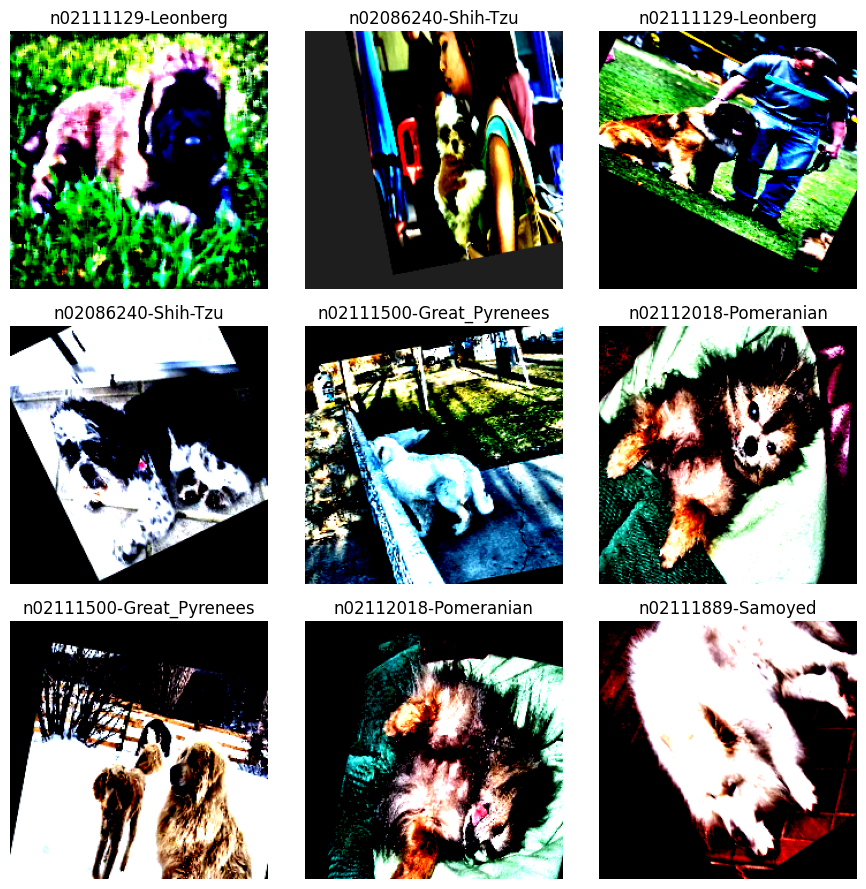

In [12]:
show_samples(train_ds, top10, 9)


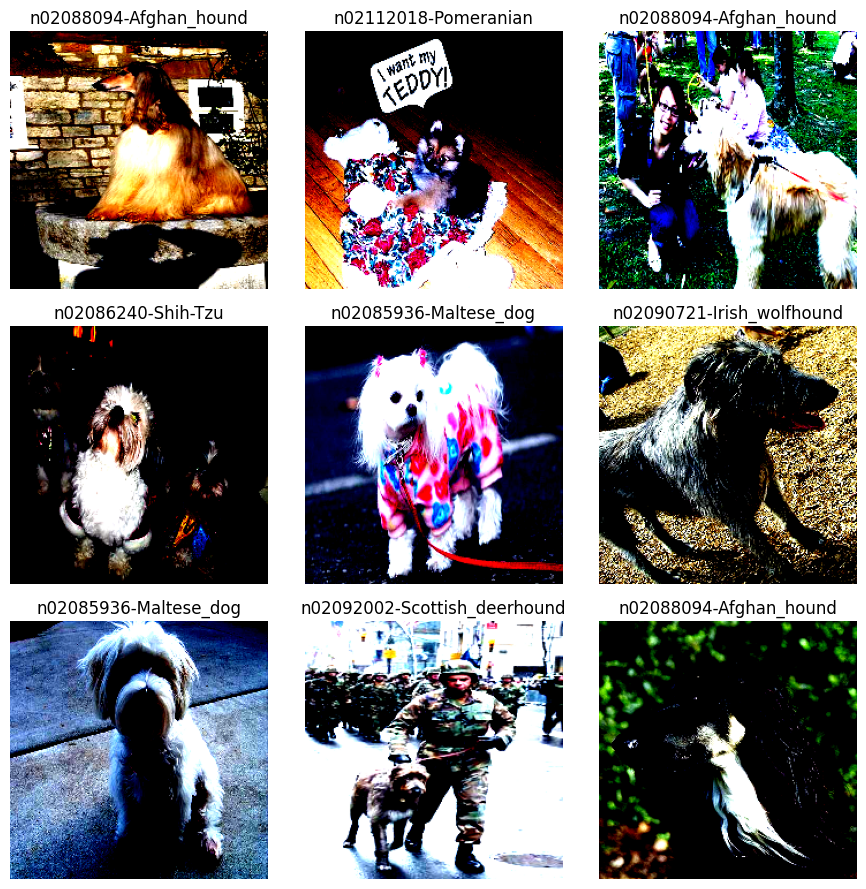

In [13]:
show_samples(val_ds, top10, 9)


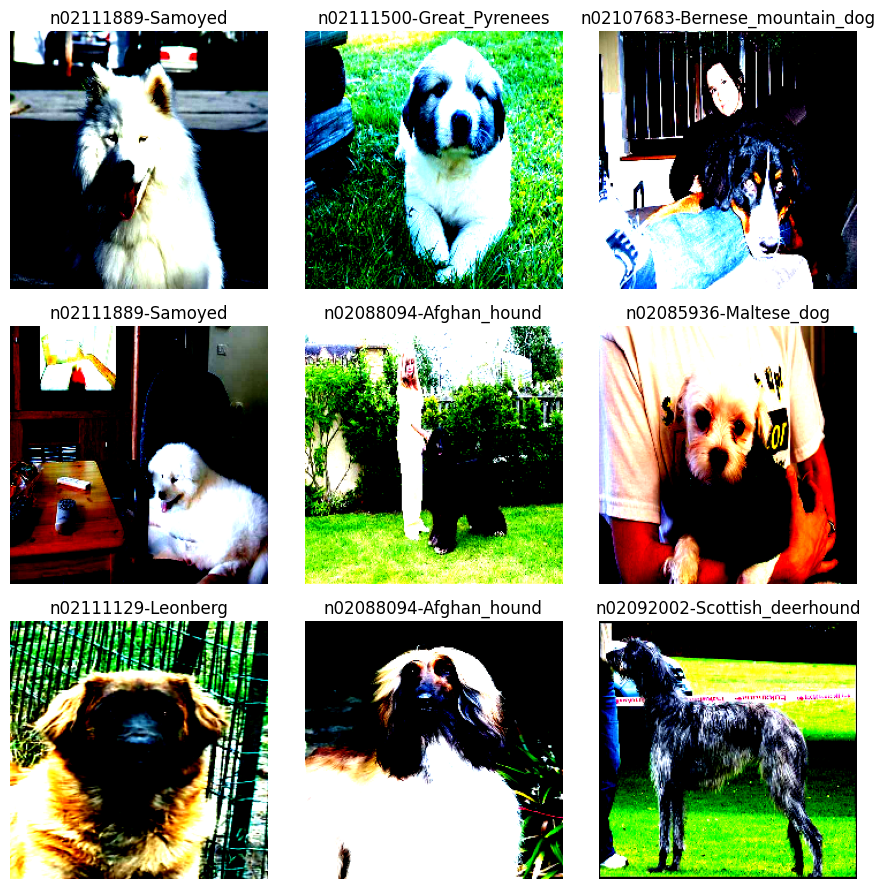

In [14]:
show_samples(test_ds, top10, 9)

## Définition du modèle CNN

In [15]:
def build_model(learning_rate=1e-3, dropout_rate1=0.4, dropout_rate2=0.6,
                activation='relu', optimizer_name='adam'):
    
    if optimizer_name == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")
    
    model = Sequential([
        Conv2D(32, kernel_size=3, padding='same', activation=activation, input_shape=(224, 224, 3)),
        MaxPooling2D(2),

        Conv2D(64, kernel_size=3, padding='same', activation=activation),
        MaxPooling2D(2),

        Conv2D(128, kernel_size=3, padding='same', activation=activation),
        MaxPooling2D(2),

        Conv2D(256, kernel_size=3, padding='same', activation=activation),
        MaxPooling2D(2),

        Dropout(dropout_rate1),
        Flatten(),

        Dense(200, activation=activation),
        Dropout(dropout_rate2),

        Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

In [16]:
def run_grid_search(train_ds, val_ds):
    learning_rates = [1e-3, 1e-4]
    dropout_rate1_values = [0.2, 0.4]
    dropout_rate2_values = [0.4, 0.6]
    activations = ['relu', 'sigmoid']
    optimizers = ['adam', 'rmsprop']
    epochs_list = [30, 50]

    best_acc = 0
    best_params = None

    for lr, dr1, dr2, act, opt, ep in itertools.product(
        learning_rates, dropout_rate1_values, dropout_rate2_values, activations, optimizers, epochs_list
    ):
        print(f"🔍 Testing: lr={lr}, dr1={dr1}, dr2={dr2}, act={act}, opt={opt}, epochs={ep}")

        model = build_model(
            learning_rate=lr,
            dropout_rate1=dr1,
            dropout_rate2=dr2,
            activation=act,
            optimizer_name=opt
        )

        history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=ep,
            verbose=0,
            #callbacks=[es]
        )

        val_acc = max(history.history['val_accuracy'])

        if val_acc > best_acc:
            best_acc = val_acc
            best_params = (lr, dr1, dr2, act, opt, ep)
            print(f"🔥 New best val_acc: {val_acc:.4f} with {best_params}")
        else:
            print(f"Val_acc = {val_acc:.4f}")
    print("\n✅ Best validation accuracy:", best_acc)
    print("✅ Best hyperparameters:", best_params)
    return best_params

In [17]:
best_params = run_grid_search(train_ds, val_ds)

best_lr, best_dr1, best_dr2, best_act, best_opt, best_epochs = best_params

🔍 Testing: lr=0.001, dr1=0.2, dr2=0.4, act=relu, opt=adam, epochs=30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1749457953.855981      62 service.cc:148] XLA service 0x7b6e34092ec0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749457953.856702      62 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1749457954.438487      62 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1749457959.734738      62 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


🔥 New best val_acc: 0.4094 with (0.001, 0.2, 0.4, 'relu', 'adam', 30)
🔍 Testing: lr=0.001, dr1=0.2, dr2=0.4, act=relu, opt=adam, epochs=50
🔥 New best val_acc: 0.4295 with (0.001, 0.2, 0.4, 'relu', 'adam', 50)
🔍 Testing: lr=0.001, dr1=0.2, dr2=0.4, act=relu, opt=rmsprop, epochs=30
Val_acc = 0.4049
🔍 Testing: lr=0.001, dr1=0.2, dr2=0.4, act=relu, opt=rmsprop, epochs=50
🔥 New best val_acc: 0.4497 with (0.001, 0.2, 0.4, 'relu', 'rmsprop', 50)
🔍 Testing: lr=0.001, dr1=0.2, dr2=0.4, act=sigmoid, opt=adam, epochs=30
Val_acc = 0.1141
🔍 Testing: lr=0.001, dr1=0.2, dr2=0.4, act=sigmoid, opt=adam, epochs=50
Val_acc = 0.1141
🔍 Testing: lr=0.001, dr1=0.2, dr2=0.4, act=sigmoid, opt=rmsprop, epochs=30
Val_acc = 0.1141
🔍 Testing: lr=0.001, dr1=0.2, dr2=0.4, act=sigmoid, opt=rmsprop, epochs=50
Val_acc = 0.1141
🔍 Testing: lr=0.001, dr1=0.2, dr2=0.6, act=relu, opt=adam, epochs=30
Val_acc = 0.3758
🔍 Testing: lr=0.001, dr1=0.2, dr2=0.6, act=relu, opt=adam, epochs=50
Val_acc = 0.4251
🔍 Testing: lr=0.001, dr

## Entraînement du modèle

In [18]:
model = build_model(best_lr, best_dr1, best_dr2, best_act, best_opt)

start_time = time.time()
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=best_epochs,
    #callbacks=[es]
)
elapsed = time.time() - start_time
print(f"Training time: {elapsed:.2f} seconds")

Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 14s 222ms/step - accuracy: 0.0870 - loss: 2.7889 - val_accuracy: 0.1454 - val_loss: 2.2956
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 170ms/step - accuracy: 0.1191 - loss: 2.2967 - val_accuracy: 0.1298 - val_loss: 2.3004
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 180ms/step - accuracy: 0.1424 - loss: 2.2990 - val_accuracy: 0.1879 - val_loss: 2.2923
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 175ms/step - accuracy: 0.1368 - loss: 2.2926 - val_accuracy: 0.1678 - val_loss: 2.2208
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 175ms/step - accuracy: 0.1534 - loss: 2.2653 - val_accuracy: 0.1834 - val_loss: 2.2239
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 172ms/step - accuracy: 0.1752 - loss: 2.2350 - val_accuracy: 0.1857 - val_loss: 2.1621
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 181ms/step - accuracy: 0.1648 - loss: 2.1977 - val_accuracy: 0.1946 - val_loss: 2.1779
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 171ms/step - accuracy: 0.1798 - loss: 2.1869 - val_accuracy: 0

## Évaluation

In [19]:
loss, acc = model.evaluate(test_ds)
print(f"Validation loss  = {loss:.3f}")
print(f"Validation accuracy = {acc:.3%}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.4492 - loss: 1.6802
Validation loss  = 1.745
Validation accuracy = 41.834%


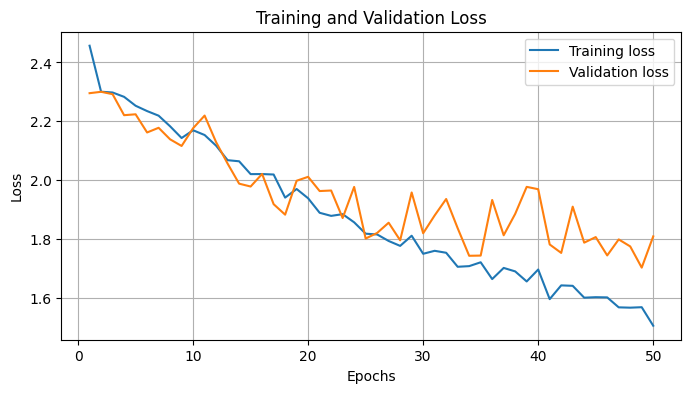

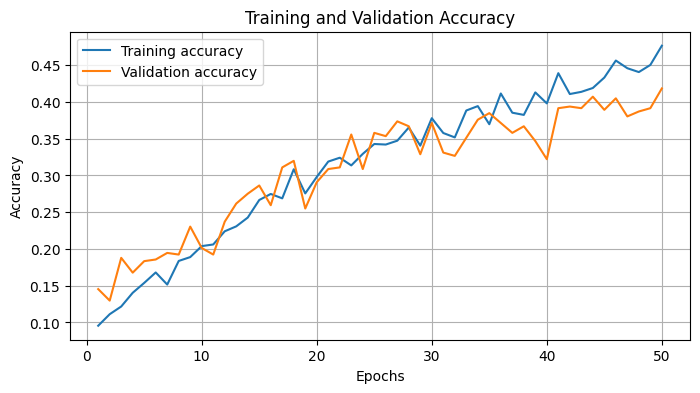

In [20]:
loss      = history.history['loss']
val_loss  = history.history.get('val_loss')
acc       = history.history.get('accuracy') or history.history.get('acc')
val_acc   = history.history.get('val_accuracy') or history.history.get('val_acc')

epochs = range(1, len(loss) + 1)

# Courbe de loss
plt.figure(figsize=(8,4))
plt.plot(epochs, loss,    label='Training loss')
if val_loss is not None:
    plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Courbe d’accuracy
if acc is not None:
    plt.figure(figsize=(8,4))
    plt.plot(epochs, acc,    label='Training accuracy')
    if val_acc is not None:
        plt.plot(epochs, val_acc, label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# Matrice de confusion

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step


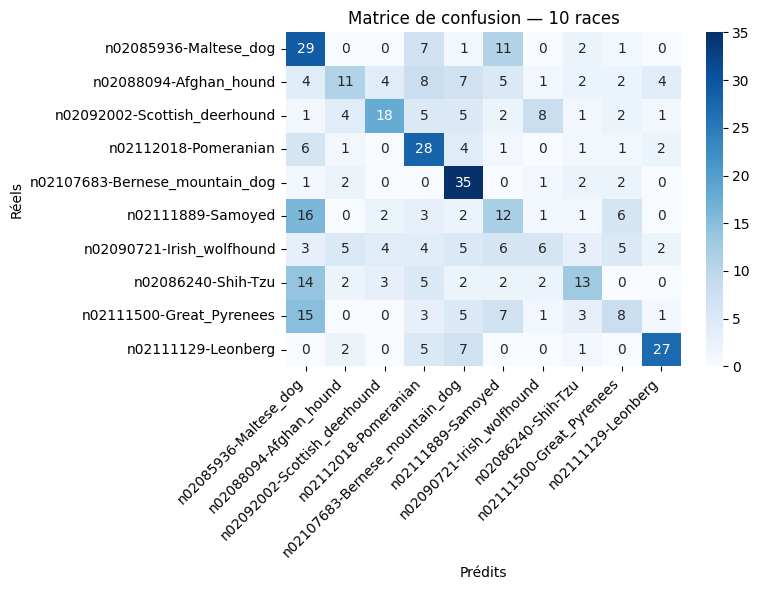

In [21]:
y_prob = model.predict(val_ds)            # shape (N, num_classes)
y_pred = np.argmax(y_prob, axis=1)        # shape (N,)

# 2) labels vrais
y_true = np.array(val_labels)             # shape (N,)

# 3) matrice de confusion
cm = confusion_matrix(y_true, y_pred)

# 3) Affichage avec heatmap
plt.figure(figsize=(8,6))
sns.heatmap(
    cm,
    annot=True, fmt="d", cmap="Blues",
    xticklabels=top10, yticklabels=top10
)
plt.xlabel("Prédits")
plt.ylabel("Réels")
plt.title("Matrice de confusion — 10 races")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [22]:
def denormalize(img, mean, std):
    return img * std + mean

def export_test_images(dataset, folder, prefix, class_names=None, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    os.makedirs(folder, exist_ok=True)
    records = []

    idx = 0
    for batch_imgs, batch_labels in dataset:
        batch_imgs = batch_imgs.numpy()
        batch_labels = batch_labels.numpy()

        for img, label in zip(batch_imgs, batch_labels):
            # transpose (H, W, C) -> (C, H, W)
            img = img.transpose(2, 0, 1)

            # Dénormalisation
            mean_arr = np.array(mean).reshape(3, 1, 1)
            std_arr = np.array(std).reshape(3, 1, 1)
            img = denormalize(img, mean_arr, std_arr)
            img = np.clip(img, 0, 1)

            # back to (H, W, C)
            img = img.transpose(1, 2, 0)
            img_uint8 = (img * 255).astype(np.uint8)

            filename = f"{prefix}_{idx:05d}.jpg"
            filepath = os.path.join(folder, filename)

            Image.fromarray(img_uint8).save(filepath)

            label_str = class_names[label] if class_names is not None else str(label)
            records.append((filename, label_str))
            idx += 1

    df = pd.DataFrame(records, columns=["filename", "true_label"])
    df.to_csv(os.path.join(folder, f"{prefix}_labels.csv"), index=False)

    print(f"{idx} images exportées vers {folder}")
    
export_test_images(test_ds, folder="/kaggle/working/test_images", prefix="test", class_names=top10)

447 images exportées vers /kaggle/working/test_images


In [23]:
EXPORT_DIR = '/kaggle/working/'

tf.data.experimental.save(train_ds, EXPORT_DIR + "train_ds")
tf.data.experimental.save(val_ds,   EXPORT_DIR + "val_ds")
tf.data.experimental.save(test_ds,  EXPORT_DIR + "test_ds")